# Finally fix this ****

(c) 2020 Tom Röschinger. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

***

In [1]:
# Julia Packages
using Plots, LinearAlgebra, LambertW, Statistics

# Custom Packages
using Jedi, Jevo

# Plotting Style
Jedi.default_gr!()

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-18362050138008284414\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-7278484266597213299\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-18362050138008284414\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

Plots.GRBackend()

## 1. Mutation-Selection Balance and possible deviations

In the first step we compute the mutation selection balance using the exponential landscape. From the computations we predict: 

$$
\Gamma_\mathrm{MSB}(l, \kappa)=\Gamma_0 - \frac{1}{\beta}\mathrm{Productlog}\left(\frac{n-1}{n^2}\frac{ 2N f_0 l \epsilon^2 \beta^2e^{\beta\Delta E}}{1+\kappa}\right)
$$

Let's compare this prediction to the numerics. Therefore we first define some parameters and a function which computes the analytical prediction.

In [2]:
Γ_0(n, l, ϵ) = (n-1)/n * l * ϵ
Γ_MSB(l, κ, n, N, f0, ϵ, β, ΔE) = Γ_0(n, l, ϵ) - 1/β * lambertw((n-1)/n^2 * 2N * f0 * l * ϵ^2 * β^2 * exp(β * ΔE) / (1 + κ))

n = 4
N = 100
f0 = 50/2N
ϵ = 1
β = 1
ΔE = 5 * ϵ
emat = ϵ * (ones(n, n) - Matrix{Float64}(I, n, n))

4×4 Array{Float64,2}:
 0.0  1.0  1.0  1.0
 1.0  0.0  1.0  1.0
 1.0  1.0  0.0  1.0
 1.0  1.0  1.0  0.0

In [3]:
F = Jevo.exponential_fitness(f0=f0, fl=0, epsilon=ϵ)

Jevo.exponential_fitness(10, 1.0, 1.0, 0.25, 0.0, Jevo.Est)

In [9]:
# Interate through driving rates
steps = 10^4

l_arr = collect(8:2:30)
κ_arr = collect(0:1:10)

t0 = zeros(length(κ_arr), length(l_arr), 100)

for (j1, κ) in enumerate(κ_arr)
    for (j2, l) in enumerate(l_arr)
        F = Jevo.exponential_fitness(f0=f0, fl=0, epsilon=ϵ, l=l)
        for r in 1:50
            pop = Jevo.mono_pop(N=N, l=l)
            Jevo.initiate!(pop, emat)
            for i in 1:steps
                Jevo.bp_substitution!(pop, emat, F)
                if rand() < κ/N
                    Jevo.driver_mutation!(pop)
                end
            end
            t0[j1, j2, r] = Jevo.get_energy(pop, emat)
        end
    end
end

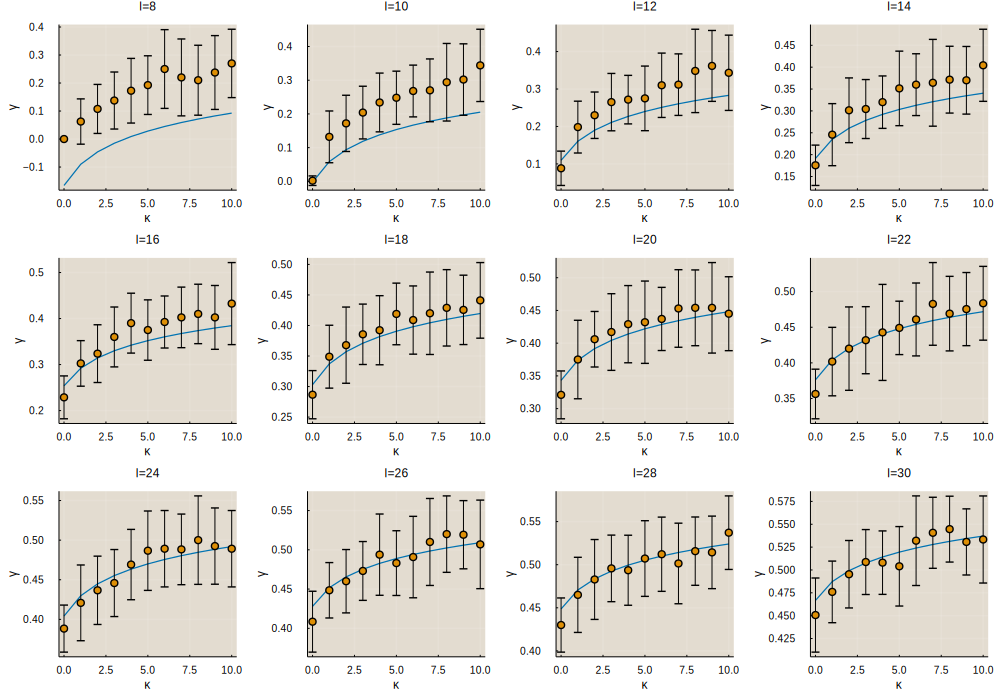

In [11]:
p_list = []
for (i, l) in enumerate(l_arr)
    prediction = [Γ_MSB(l, κ, n, N, f0, ϵ, β, ΔE)/(l*ϵ) for κ in κ_arr]
    simulation_mean = mean(t0[:, i, 1:50] ./ (l*ϵ), dims=2)
    simulation_std = std(t0[:, i, 1:50] ./(l*ϵ), dims=2)
    p = plot(κ_arr, prediction, title="l=$l", xlabel="κ", ylabel="γ")
    scatter!(p, κ_arr, simulation_mean, yerror=simulation_std)
    push!(p_list, p)
end

plot(p_list..., size=(1000, 700))

## 2. Genetic Load at Mutation Selection balance

$$
\mathcal{L}= -\frac{2N f^\prime(\Gamma_\mathrm{MSB}, l)}{\beta}
$$


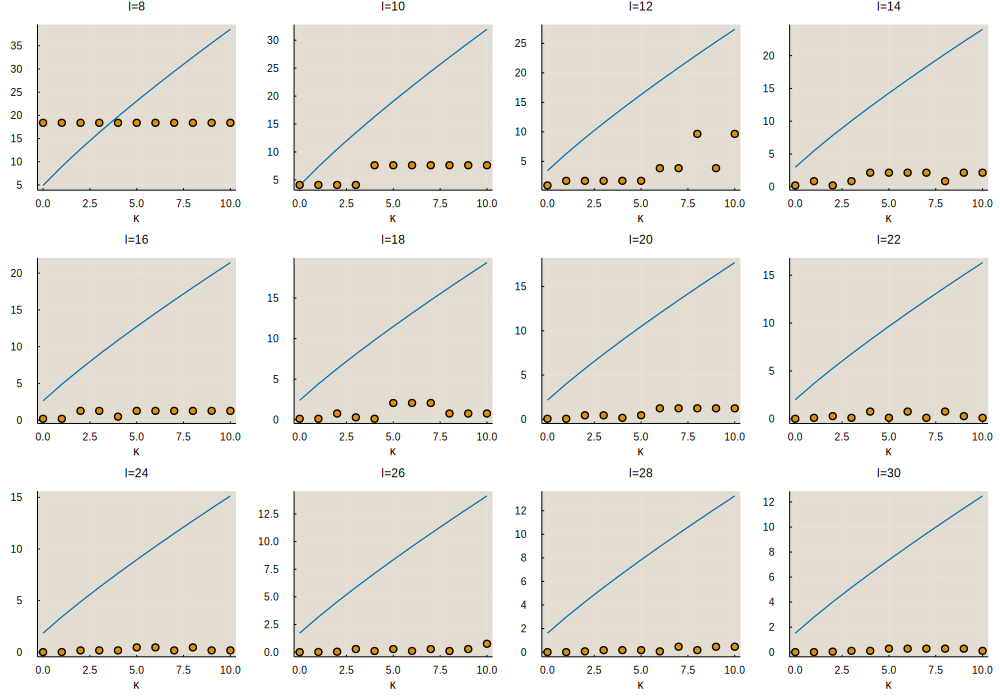

In [6]:
p_list = []
for (i, l) in enumerate(l_arr)
    prediction = 2N .* [f0 - Jevo.fitness(Γ_MSB(l, κ, n, N, f0, ϵ, β, ΔE), l, F) for κ in κ_arr]
    simulation_mean = 2N .* median(f0 .- Jevo.fitness.(t0[:, i, :], l, F), dims=2)
    simulation_std = 2N .* std(f0 .- Jevo.fitness.(t0[:, i, :], l, F), dims=2)
    p = plot(κ_arr, prediction, title="l=$l", xlabel="κ")
    scatter!(p, κ_arr, simulation_mean)#, yerror=simulation_std)
    push!(p_list, p)
end

plot(p_list..., size=(1000, 700))

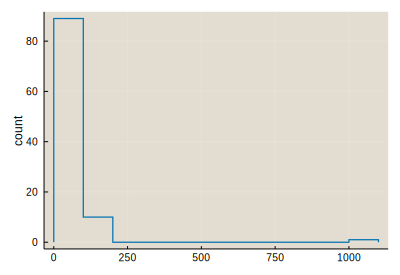

In [172]:
Jedi.histogram(data=2N .* (f0 .- Jevo.fitness.(t0[end, end, :], 30, F)))

In [179]:
median(2N .* (f0 .- Jevo.fitness.(t0[5, end, :], 30, F)))

6.989353418393196

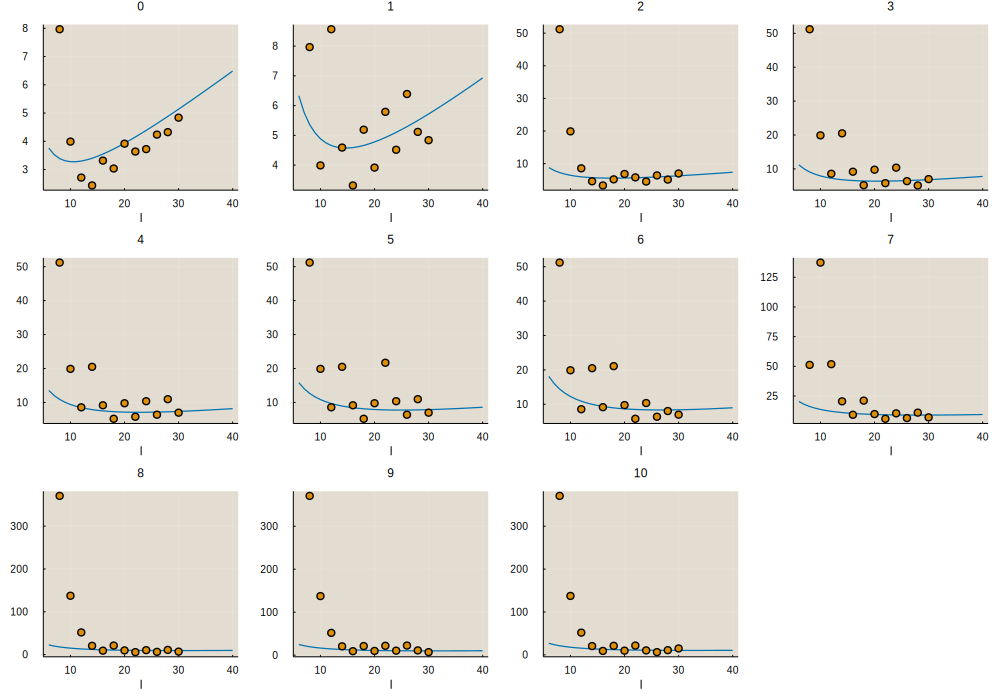

In [160]:
p_list = []
F.fl = 0.15/2N
for (i, κ) in enumerate(κ_arr)
    prediction = 2N .* [f0 - Jevo.fitness(Γ_MSB(l, κ, n, N, f0, ϵ, β, ΔE), l, F) for l in 6:40]
    simulation_mean = 2N .* median(hcat([f0 .- Jevo.fitness.(t0[i, j, :], l, F) for (j, l) in enumerate(l_arr)]...), dims=1)'
    #simulation_std = 2N .* std(f0 .- Jevo.fitness.(t0[i, :, :], l, F), dims=1)
    p = plot(6:40, prediction, title=κ, xlabel="l")
    scatter!(p, l_arr, simulation_mean)#, yerror=simulation_std)
    push!(p_list, p)
end

plot(p_list..., size=(1000, 700))

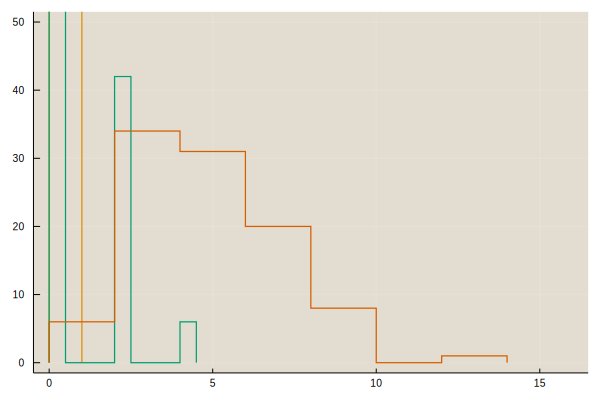

In [180]:
p = plot(0:0.1:16, 2N .* Jevo.fitness.(collect(0:0.1:16), 8, F), ylims=[0, 2N .* f0])
Jedi.histogram(p=p, data=t0[1, 1, :])
Jedi.histogram(p=p, data=t0[2, 1, :])
Jedi.histogram(p=p, data=t0[end, 1, :])

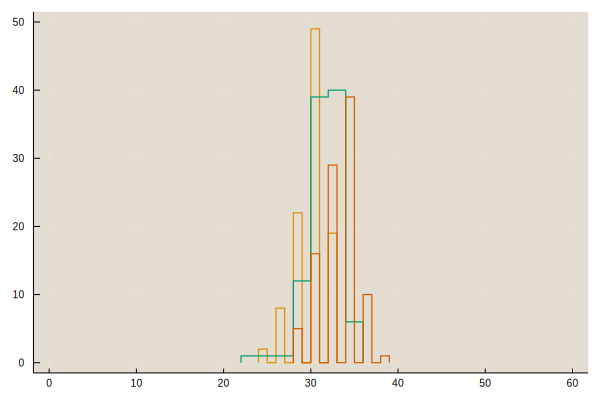

In [158]:
p = plot(0:0.1:60, 2N .* Jevo.fitness.(collect(0:0.1:60), 30, F), ylims=[0, 2N .* f0])
Jedi.histogram(p=p, data=t0[1, end, :])
Jedi.histogram(p=p, data=t0[2, end, :])
Jedi.histogram(p=p, data=t0[end, end, :])